In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn as sk
import sklearn.model_selection
import pandas as pd
import cv2

In [3]:
npzfile = np.load('./gdrive/MyDrive/USF Year 3 Semester 2/MATH 373/Final Project/train_data.npz')
npzfile_test = np.load('./gdrive/MyDrive/USF Year 3 Semester 2/MATH 373/Final Project/test_images.npz')

X = npzfile['X']
y = npzfile['y']

X_test = npzfile_test['X']

In [4]:
class NucleusDataset():
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    xi = torch.tensor(self.X[i])
    yi = torch.tensor(self.y[i])

    xi = torch.reshape(xi, (1, 128, 128)) #for images in a conv neural network needs to have this shape input
    yi = torch.reshape(yi, (1, 128, 128))

    return xi, yi

In [5]:
class NucleusDatasetUnlabeled():
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    xi = torch.tensor(self.X[i])

    xi = torch.reshape(xi, (1,128,128))

    return xi

In [6]:
class UNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, padding='same')
    self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding='same')

    self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding='same')
    self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=3, padding='same')

    self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, padding='same')
    self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding='same')

    self.conv7 = torch.nn.Conv2d(256, 512, kernel_size=3, padding='same')
    self.conv8 = torch.nn.Conv2d(512, 512, kernel_size=3, padding='same')

    self.conv9 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding='same')
    self.conv10 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding='same')

    self.conv11 = torch.nn.Conv2d(1024, 512, kernel_size=2, padding='same')
    self.conv12 = torch.nn.Conv2d(1024, 512, kernel_size=3, padding='same')
    self.conv13 = torch.nn.Conv2d(512, 512, kernel_size=3, padding='same')

    self.conv14 = torch.nn.Conv2d(512, 256, kernel_size=2, padding='same')
    self.conv15 = torch.nn.Conv2d(512, 256, kernel_size=3, padding='same')
    self.conv16 = torch.nn.Conv2d(256, 256, kernel_size=3, padding='same')

    self.conv17 = torch.nn.Conv2d(256, 128, kernel_size=2, padding='same')
    self.conv18 = torch.nn.Conv2d(256, 128, kernel_size=3, padding='same')
    self.conv19 = torch.nn.Conv2d(128, 128, kernel_size=3, padding='same')

    self.conv20 = torch.nn.Conv2d(128, 64, kernel_size=2, padding='same')
    self.conv21 = torch.nn.Conv2d(128, 64, kernel_size=3, padding='same')
    self.conv22 = torch.nn.Conv2d(64, 64, kernel_size=3, padding='same')
    
    self.conv23 = torch.nn.Conv2d(64, 1, kernel_size=1)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.nn.functional.relu(x)
    x = self.conv2(x)
    x1 = torch.nn.functional.relu(x)
    x = torch.nn.functional.max_pool2d(x1, kernel_size=2)

    x = self.conv3(x)
    x = torch.nn.functional.relu(x)
    x = self.conv4(x)
    x2 = torch.nn.functional.relu(x)
    x = torch.nn.functional.max_pool2d(x2, kernel_size=2)

    x = self.conv5(x)
    x = torch.nn.functional.relu(x)
    x = self.conv6(x)
    x3 = torch.nn.functional.relu(x)
    x = torch.nn.functional.max_pool2d(x3, kernel_size=2)

    x = self.conv7(x)
    x = torch.nn.functional.relu(x)
    x = self.conv8(x)
    x4 = torch.nn.functional.relu(x)
    x = torch.nn.functional.max_pool2d(x4, kernel_size=2)

    x = self.conv9(x)
    x = torch.nn.functional.relu(x)
    x = self.conv10(x)
    x = torch.nn.functional.relu(x)

    x = torch.nn.functional.upsample(x, scale_factor=2)
    x = self.conv11(x)
    x = self.conv12(torch.cat((x, x4), dim=1))
    x = torch.nn.functional.relu(x)
    x = self.conv13(x)
    x = torch.nn.functional.relu(x)

    x = torch.nn.functional.upsample(x, scale_factor=2)
    x = self.conv14(x)
    x = self.conv15(torch.cat((x, x3), dim=1))
    x = torch.nn.functional.relu(x)
    x = self.conv16(x)
    x = torch.nn.functional.relu(x)

    x = torch.nn.functional.upsample(x, scale_factor=2)
    x = self.conv17(x)
    x = self.conv18(torch.cat((x, x2), dim=1))
    x = torch.nn.functional.relu(x)
    x = self.conv19(x)
    x = torch.nn.functional.relu(x)

    x = torch.nn.functional.upsample(x, scale_factor=2)
    x = self.conv20(x)
    x = self.conv21(torch.cat((x, x1), dim=1))
    x = torch.nn.functional.relu(x)
    x = self.conv22(x)
    x = torch.nn.functional.relu(x)

    x = self.conv23(x)

    return(x)


In [7]:
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y)

In [8]:
dataset_train = NucleusDataset(X_train, y_train)
dataset_val = NucleusDataset(X_val, y_val)
dataset_train_true = NucleusDataset(X, y)

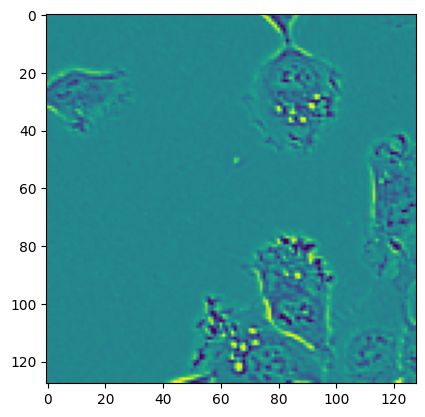

In [ ]:
i = np.random.randint(len(dataset_train))
xi, yi = dataset_train.__getitem__(i)
plt.imshow(torch.reshape(xi, (128, 128)))

In [9]:
torch.cuda.is_available()
device = torch.device('cuda')

In [10]:
model = UNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

In [12]:
num_epochs = 20
L_history_train = []
L_history_val = []

for ep in range(num_epochs):

  model.train()
  L = 0

  for x_batch, y_batch in dataloader_train:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model(x_batch)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, y_batch) #logits -- values before applying sigmoid
    L += loss*len(x_batch)
    model.zero_grad() #Erase any previous gradient calculations
    loss.backward()
    optimizer.step()

  L = L / len(dataset_train)
  L_history_train.append(L.item())
  print(f'Justfinished epoch: ', ep)
  print(f'L value (training):', L.item())


  model.eval()
  L = 0
  for x_batch, y_batch in dataloader_val:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
      outputs = model(x_batch)
      loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, y_batch)
      L += loss*len(x_batch)

  L = L / len(dataset_val)
  L_history_val.append(L.item())
  print(f'L value (val):', L.item())




Justfinished epoch:  0
L value (training): 0.6753776669502258
L value (val): 0.47838348150253296
Justfinished epoch:  1
L value (training): 0.4443298578262329
L value (val): 0.399230033159256
Justfinished epoch:  2
L value (training): 0.3987876772880554
L value (val): 0.3859393000602722
Justfinished epoch:  3
L value (training): 0.3826601207256317
L value (val): 0.38112717866897583
Justfinished epoch:  4
L value (training): 0.37151429057121277
L value (val): 0.46618807315826416
Justfinished epoch:  5
L value (training): 0.38344278931617737
L value (val): 0.3704064190387726
Justfinished epoch:  6
L value (training): 0.41986528038978577
L value (val): 0.39294999837875366
Justfinished epoch:  7
L value (training): 0.39214053750038147
L value (val): 0.427480012178421
Justfinished epoch:  8
L value (training): 0.3905301094055176
L value (val): 0.371171772480011
Justfinished epoch:  9
L value (training): 0.3564216196537018
L value (val): 0.3355102837085724
Justfinished epoch:  10
L value (tr

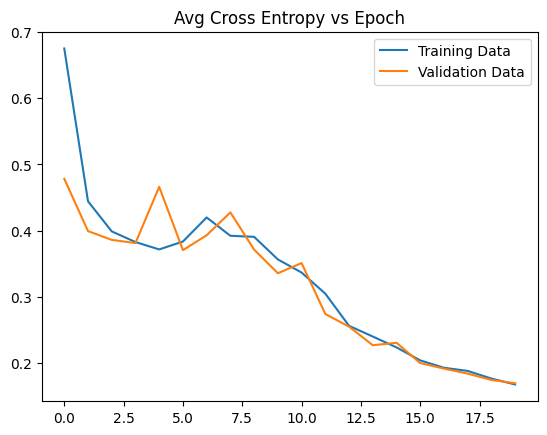

In [13]:
plt.figure()
plt.plot(L_history_train, label='Training Data')
plt.plot(L_history_val, label='Validation Data')
plt.title('Avg Cross Entropy vs Epoch')
plt.legend()

In [10]:
model2 = UNet()
model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
dataloader_train_true = torch.utils.data.DataLoader(dataset_train_true, batch_size=64, shuffle=True)

In [11]:
num_epochs = 20
L_history_train_true = []


for ep in range(num_epochs):
  model2.train()
  L = 0

  for x_batch, y_batch in dataloader_train_true:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model2(x_batch)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, y_batch) #logits -- values before applying sigmoid
    L += loss*len(x_batch)
    model2.zero_grad() #Erase any previous gradient calculations
    loss.backward()
    optimizer2.step()

  L = L / len(dataset_train_true)
  L_history_train_true.append(L.item())
  print(f'Justfinished epoch: ', ep)
  print(f'L value (training):', L.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Justfinished epoch:  0
L value (training): 5230163968.0
Justfinished epoch:  1
L value (training): 0.5427561402320862
Justfinished epoch:  2
L value (training): 0.49335139989852905
Justfinished epoch:  3
L value (training): 0.39379310607910156
Justfinished epoch:  4
L value (training): 0.38195598125457764
Justfinished epoch:  5
L value (training): 0.3786126673221588
Justfinished epoch:  6
L value (training): 0.3787240982055664
Justfinished epoch:  7
L value (training): 0.37479937076568604
Justfinished epoch:  8
L value (training): 0.37391820549964905
Justfinished epoch:  9
L value (training): 0.37328431010246277
Justfinished epoch:  10
L value (training): 0.3701466917991638
Justfinished epoch:  11
L value (training): 0.3701445162296295
Justfinished epoch:  12
L value (training): 0.3678942024707794
Justfinished epoch:  13
L value (training): 0.3649561107158661
Justfinished epoch:  14
L value (training): 0.3638487756252289
Justfinished epoch:  15
L value (training): 0.36295485496520996
J

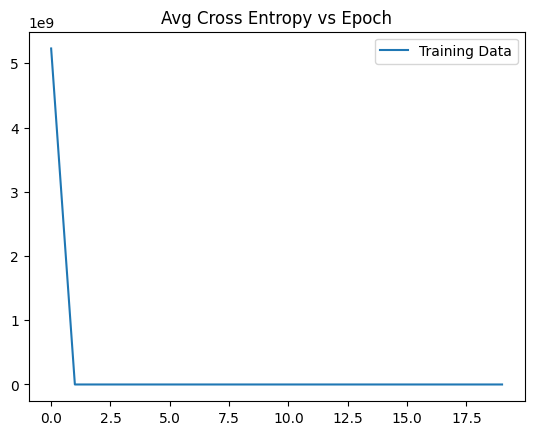

In [12]:
plt.figure()
plt.plot(L_history_train_true, label='Training Data')
plt.title('Avg Cross Entropy vs Epoch')
plt.legend()

In [13]:
dataset_test = NucleusDatasetUnlabeled(X_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False)

In [17]:
counts_pred = []
y_preds = []
model2.eval()
for x_batch in dataloader_test:
  x_batch = x_batch.to(device)

  with torch.no_grad():
    outputs = model2(x_batch)
    outputs = outputs.cpu()
    probabilities = torch.nn.functional.sigmoid(outputs)
    probabilities = probabilities.numpy()
    y_pred_test = np.round(probabilities)
    y_preds = y_preds + [y for y in y_pred_test]

In [18]:
for y in y_preds:
  #y = np.round(y)
  y = y.reshape((128,128))
  counts, labels = cv2.connectedComponents(np.uint8(y))
  counts_pred = counts_pred + [counts - 1]


In [19]:
indx = np.arange(len(X_test))
d = {'index':indx, 'count':counts_pred}
k_sub = pd.DataFrame(d)
k_sub.to_csv('myKaggleSubCellCounts.csv', index=False)

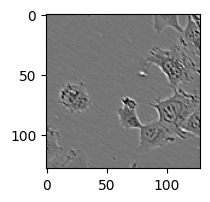

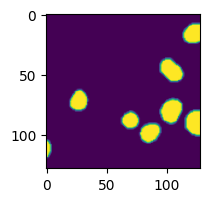

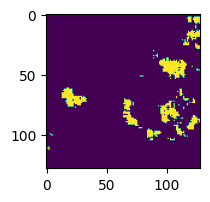

In [16]:
x_batch, y_batch = next(iter(dataloader_train_true))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
with torch.no_grad():
  y_pred_ex = model2(x_batch)
y_pred_ex = y_pred_ex.cpu()
y_pred_ex = torch.nn.functional.sigmoid(y_pred_ex)
y_pred_ex = y_pred_ex.numpy()
labels_pred_ex = np.round(y_pred_ex)
x_batch = x_batch.cpu()
y_batch = y_batch.cpu()
plt.figure(figsize=(2,2))
i = 0
plt.imshow(x_batch[i].reshape((128,128)), cmap='gray')
plt.figure(figsize=(2,2))
plt.imshow(y_batch[i].reshape((128,128)))
plt.figure(figsize=(2,2))
plt.imshow(labels_pred_ex[i].reshape((128,128)))